Parametric Test for Performance

Processing 892
Good events: 43729
Bad events: 193


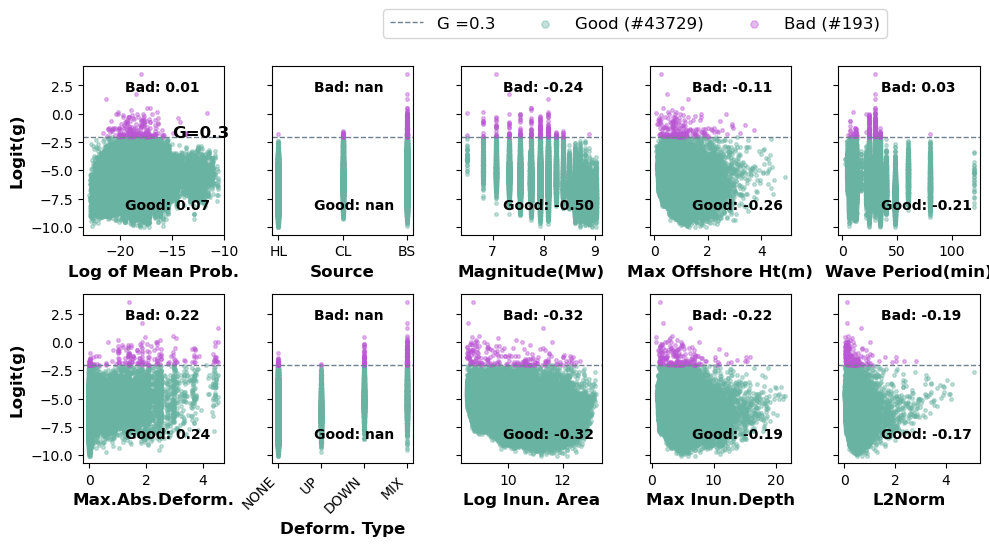

Processing 1658
Good events: 43064
Bad events: 117


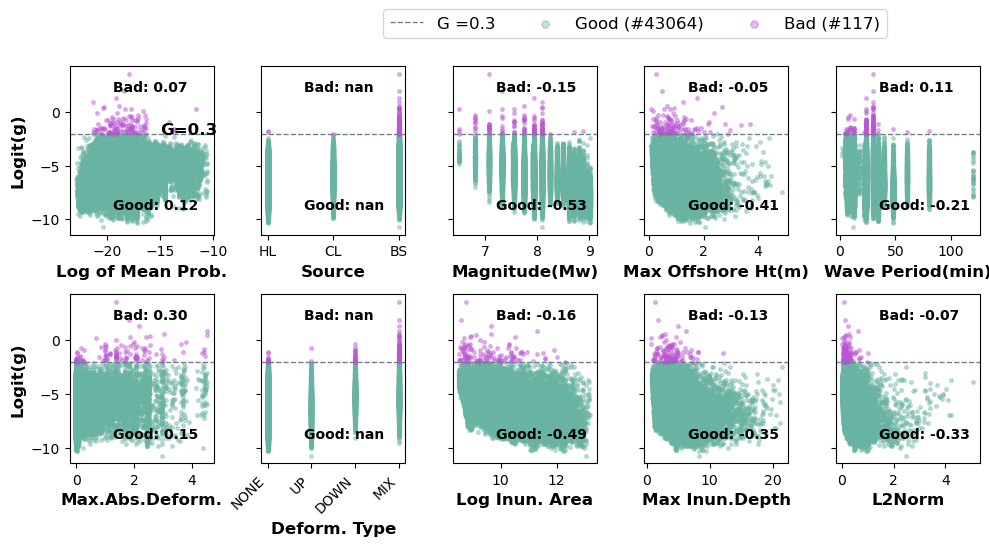

Processing 3454
Good events: 41402
Bad events: 74


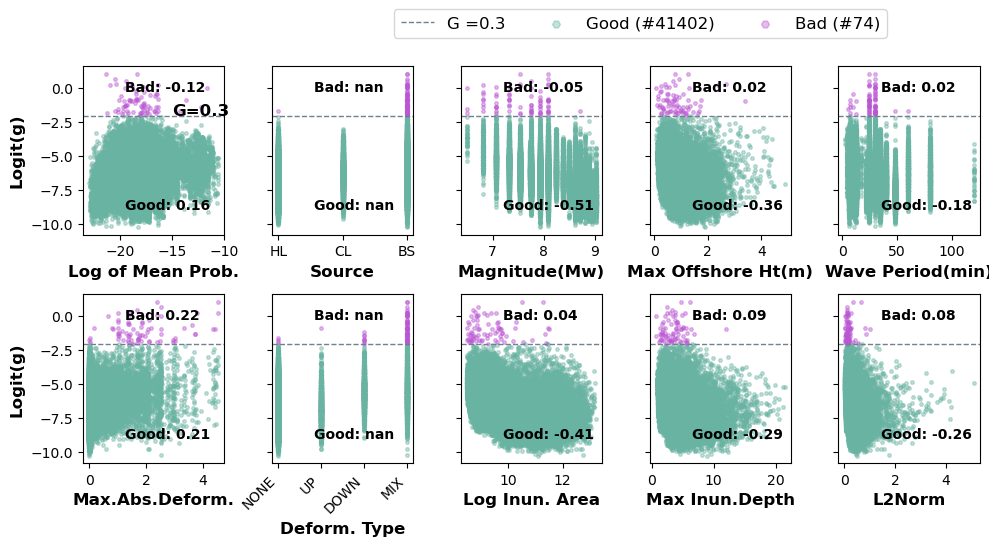

Processing 7071
Good events: 38016
Bad events: 44


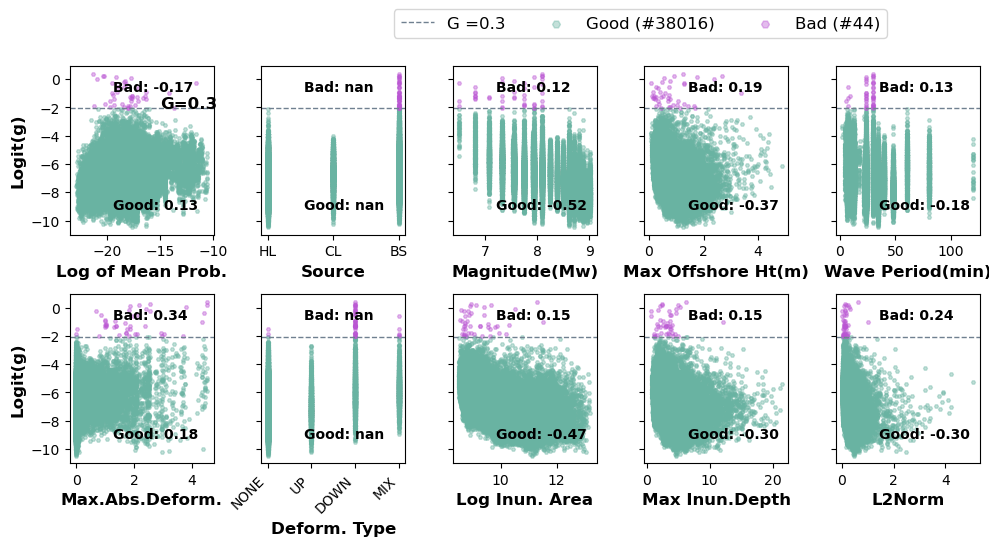

In [1]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr
import statsmodels.api as sm
from statsmodels.formula.api import ols


#select particular representative gauge
reg = 'CT'
if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

for train_size in list_size[:]:
    print(f'Processing {train_size}')

    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_direct_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
    eve_perf = eve_perf[eve_perf['g'] < 1]
    eve_perf = eve_perf[eve_perf['split'] == 'test']
    eve_perf = eve_perf[eve_perf['g'] > 0]

    #calculate logit of column g
    eve_perf['logit_g'] = np.log(eve_perf['g']*eve_perf['g']/(1-eve_perf['g']))

    eve_perf['log_count'] = np.log(eve_perf['count'])
 
    #add polarity to the deformation values based on range given by dzmax, dzmin
    # 0 if positive and negative value, -1 if ony negative and 1 if only positive
    eve_perf['dz_type'] = np.where((eve_perf['dzmax'] < 0) & (eve_perf['dzmin'] < 0), 'DOWN',
                                    np.where((eve_perf['dzmax'] > 0) & (eve_perf['dzmin'] > 0), 'UP', 'MIX'))
    #if max_absdz is greater than 0.1, then it is a significant event otherwise mark as dz_type as nan
    eve_perf['dz_type'] = np.where(eve_perf['max_absdz'] > 0.1, eve_perf['dz_type'], 'NONE')
    #divide good and bad events based on g value >0.3
    eve_perf['good'] = np.where(eve_perf['g'] > 0.3,0,1)

    # #plot g and logit(g) distribution for good and bad events
    # fig, ax = plt.subplots(1,2, figsize=(10,5))
    # ax[0].hist(eve_perf['g'][eve_perf['good'] == 0], bins=100, alpha=0.2, color='b', label='bad')
    # ax[0].hist(eve_perf['g'][eve_perf['good'] == 1], bins=100, alpha=0.2, color='g', label='good')
    # ax[0].set_xlabel('g')
    # ax[0].set_ylabel('Frequency')
    # ax[0].set_title('g distribution')
    # ax[0].legend()
    # ax[1].hist(eve_perf['logit_g'][eve_perf['good'] == 0], bins=100, alpha=0.2, color='b', label='bad')
    # ax[1].hist(eve_perf['logit_g'][eve_perf['good'] == 1], bins=100, alpha=0.2, color='g', label='good')
    # ax[1].set_xlabel('logit(g)')
    # ax[1].set_ylabel('Frequency')
    # ax[1].set_title('logit(g) distribution')
    # ax[1].legend()
    # plt.show()

    #variables to use anova test on logitg performance
    # Index(['Unnamed: 0', 'mse', 'r2', 'g', 'l2n', 'true', 'pred', 'truemax',
    #        'predmax', 'id', 'eve_id', 'max_off', 'wave_period', 'dominant_period',
    #        'mean_prob', 'dzmax', 'dzmin', 'count', 'dmax', 'lon', 'lat',
    #        'Location', 'LocationCount', 'max_absdz', 'event_type', 'importance',
    #        'uniform_wt', 'gridcount', 'grid_id', 'max_off_bin', 'split', 'Mag',
    #        'SR', 'logit_g','dz_type'],
    #       dtype='object')

    # # Define the formula for the multi-way ANOVA model
    # # If your parameters are continuous, do not use C() for them
    # formula = 'logit_g ~ Mag + max_off + SR  +Mag:max_off + Mag:SR + max_off:SR'
    # # Fit the linear model
    # lm = ols(formula, eve_perf).fit()
    # print(lm.summary())
    # # Perform the ANOVA
    # table = sm.stats.anova_lm(lm, typ=2)
    # print(table)

    #calculate the correlation between logit(g) and other variables for good and bad events
    # for var in ['Mag', 'max_off', 'dz_type', 'max_absdz', 'mean_prob', 'wave_period', 'dominant_period', 'log_count']:
    #     print(f'Correlation between logit(g) and {var}')
    #     print(f'Good events: {np.corrcoef(eve_perf["logit_g"][eve_perf["good"] == 1], eve_perf[var][eve_perf["good"] == 1])[0,1]}')
    #     print(f'Bad events: {np.corrcoef(eve_perf["logit_g"][eve_perf["good"] == 0], eve_perf[var][eve_perf["good"] == 0])[0,1]}')

    #plot the correlation between logit(g) and other variables for good and bad events
    # Filtering the DataFrame
    eve_perf = eve_perf[eve_perf['count'] > 5000]

    # Print counts
    print(f'Good events: {eve_perf["good"].sum()}')
    print(f'Bad events: {eve_perf["good"].count() - eve_perf["good"].sum()}')

    # Converting counts to strings for labels
    good_count = eve_perf["good"].sum().astype(str)
    bad_count = (eve_perf["good"].count() - eve_perf["good"].sum()).astype(str)

    # Variable labels
    var_label = ['Log of Mean Prob.', 'Source', 'Magnitude(Mw)', 'Max Offshore Ht(m)','Wave Period(min)',
                  'Max.Abs.Deform.', 'Deform. Type', 'Log Inun. Area', 'Max Inun.Depth', 'L2Norm']

    # Create subplots
    fig, ax = plt.subplots(2, 5, figsize=(10, 5), sharey=True)
    ax = ax.flatten()
    # Loop through variables to create scatter plots
    for i, var in enumerate(['mean_prob', 'SR', 'Mag', 'max_off', 'dominant_period', 'max_absdz', 'dz_type', 'log_count', 'dmax','l2n']):
        #add horizontal line at g=0.3 as logit value 
        logit_0pt3 = np.log(0.3*0.3/(1-0.3))
        
        ax[i].axhline(y=logit_0pt3, color='slategrey', linestyle='--', linewidth=1)
        
        if var == 'mean_prob':  # Use log for 'mean_prob'
            eve_perf[var] = np.log(eve_perf[var])
        
        ax[i].set_xlabel(var_label[i], fontsize=12, fontweight='bold')
        if i == 0:
            ax[i].text(-15, logit_0pt3, 'G=0.3', fontsize=12, fontweight='bold', color='k')
        if i == 0 or i == 5:
            ax[i].set_ylabel('Logit(g)', fontsize=12, fontweight='bold')
        # Scatter plot for good events
        ax[i].scatter(eve_perf[var][eve_perf['good'] == 1], eve_perf['logit_g'][eve_perf['good'] == 1], 
                      alpha=0.4, color='#69b3a2', label='good', s=8,marker = 'H')
        # Scatter plot for bad events
        ax[i].scatter(eve_perf[var][eve_perf['good'] == 0], eve_perf['logit_g'][eve_perf['good'] == 0], 
                      alpha=0.4, color='mediumorchid', label='bad', s=8,marker = 'H')
        
        # Convert variable to numeric
        eve_perf[var] = pd.to_numeric(eve_perf[var], errors='coerce')
        
        # Calculate and display correlations
        good_corr = np.corrcoef(eve_perf[var][eve_perf["good"] == 1], eve_perf["logit_g"][eve_perf["good"] == 1])[0, 1]
        bad_corr = np.corrcoef(eve_perf[var][eve_perf["good"] == 0], eve_perf["logit_g"][eve_perf["good"] == 0])[0, 1]
        ax[i].text(0.3, 0.15, f'Good: {good_corr:.2f}', transform=ax[i].transAxes, fontsize=10, fontweight='bold', color='k')
        ax[i].text(0.3, 0.85, f'Bad: {bad_corr:.2f}', transform=ax[i].transAxes, fontsize=10, fontweight='bold', color='k')
        
        # Set custom ticks for 'dz_type'
        if var == 'dz_type':
            ax[i].set_xticks([0, 1, 2, 3])
            ax[i].set_xticklabels(['NONE', 'UP', 'DOWN', 'MIX'], rotation=45, ha='right')

    # Add common legend outside the plot
    fig.legend([f'G =0.3',f'Good (#{good_count})', f'Bad (#{bad_count})'], loc='upper right',
                bbox_to_anchor=(0.9, 1.1), ncol=3, fontsize=12, markerscale=2)

    # Use tight layout to avoid overlap
    plt.tight_layout()

    # Show plot
    plt.savefig(f'plots/logitg_corr_{train_size}_{reg}.png', dpi=300, bbox_inches='tight')
    plt.show()

Processing 961


Good events: 32175
Bad events: 579


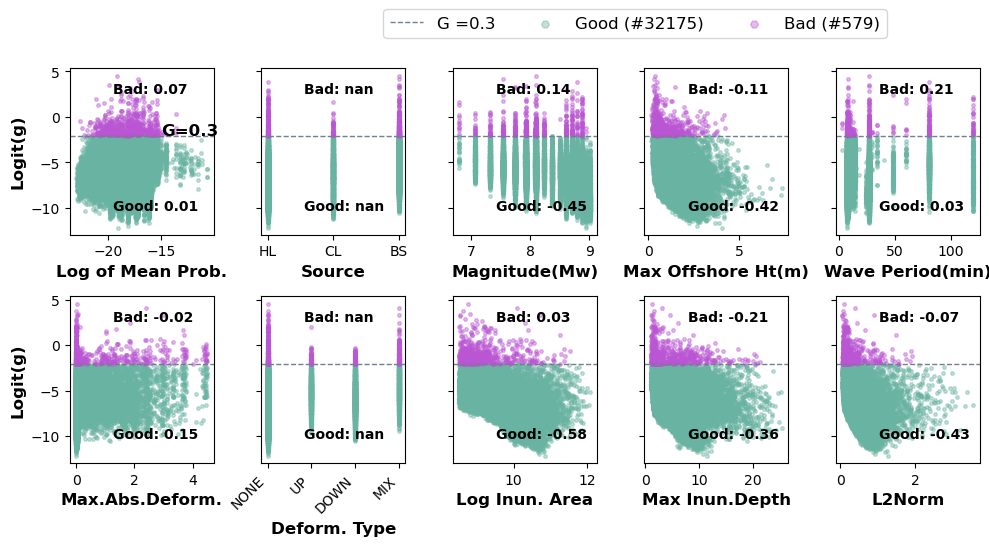

Processing 1773
Good events: 31717
Bad events: 360


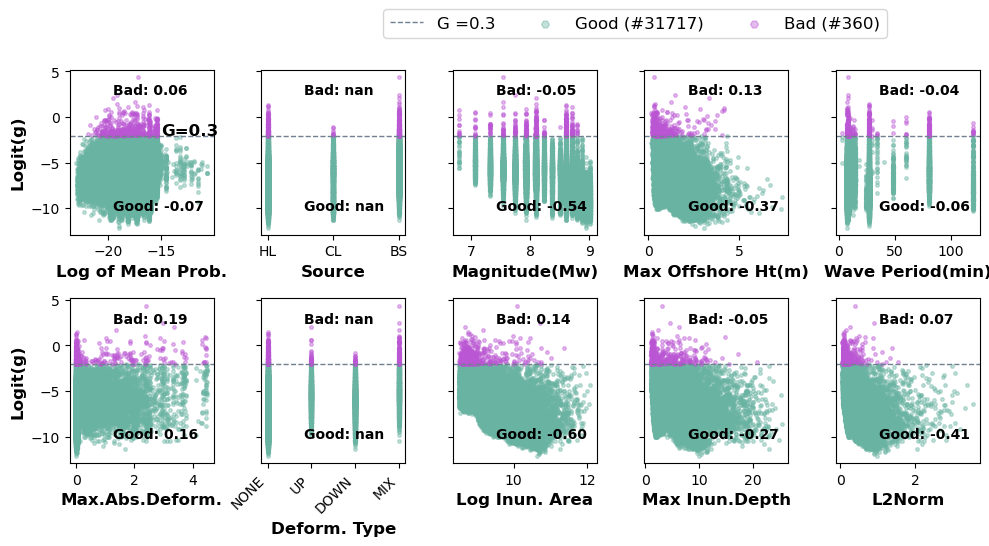

Processing 3669
Good events: 30389
Bad events: 111


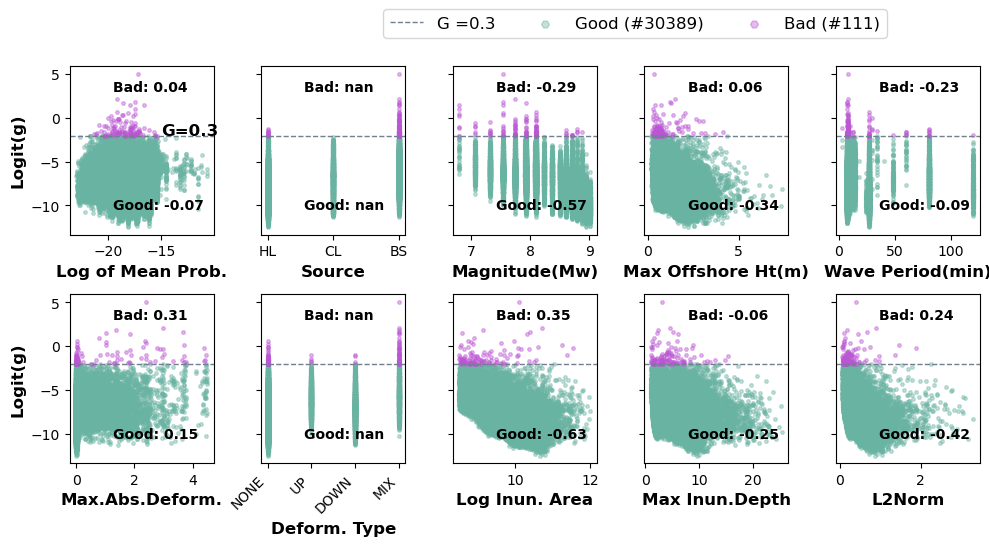

Processing 6941
Good events: 27681
Bad events: 147


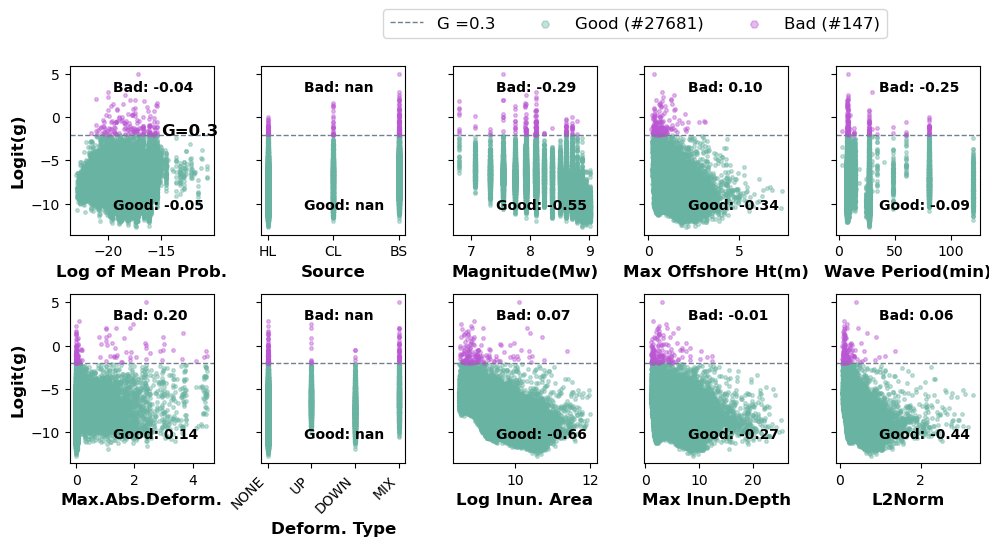

In [2]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr
import statsmodels.api as sm
from statsmodels.formula.api import ols


#select particular representative gauge
reg = 'SR'
if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

for train_size in list_size[:]:
    print(f'Processing {train_size}')

    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_coupled_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
    eve_perf = eve_perf[eve_perf['g'] < 1]
    eve_perf = eve_perf[eve_perf['split'] == 'test']
    eve_perf = eve_perf[eve_perf['g'] > 0]

    #calculate logit of column g
    eve_perf['logit_g'] = np.log(eve_perf['g']*eve_perf['g']/(1-eve_perf['g']))

    eve_perf['log_count'] = np.log(eve_perf['count'])
 
    #add polarity to the deformation values based on range given by dzmax, dzmin
    # 0 if positive and negative value, -1 if ony negative and 1 if only positive
    eve_perf['dz_type'] = np.where((eve_perf['dzmax'] < 0) & (eve_perf['dzmin'] < 0), 'DOWN',
                                    np.where((eve_perf['dzmax'] > 0) & (eve_perf['dzmin'] > 0), 'UP', 'MIX'))
    #if max_absdz is greater than 0.1, then it is a significant event otherwise mark as dz_type as nan
    eve_perf['dz_type'] = np.where(eve_perf['max_absdz'] > 0.1, eve_perf['dz_type'], 'NONE')
    #divide good and bad events based on g value >0.3
    eve_perf['good'] = np.where(eve_perf['g'] > 0.3,0,1)

    # #plot g and logit(g) distribution for good and bad events
    # fig, ax = plt.subplots(1,2, figsize=(10,5))
    # ax[0].hist(eve_perf['g'][eve_perf['good'] == 0], bins=100, alpha=0.2, color='b', label='bad')
    # ax[0].hist(eve_perf['g'][eve_perf['good'] == 1], bins=100, alpha=0.2, color='g', label='good')
    # ax[0].set_xlabel('g')
    # ax[0].set_ylabel('Frequency')
    # ax[0].set_title('g distribution')
    # ax[0].legend()
    # ax[1].hist(eve_perf['logit_g'][eve_perf['good'] == 0], bins=100, alpha=0.2, color='b', label='bad')
    # ax[1].hist(eve_perf['logit_g'][eve_perf['good'] == 1], bins=100, alpha=0.2, color='g', label='good')
    # ax[1].set_xlabel('logit(g)')
    # ax[1].set_ylabel('Frequency')
    # ax[1].set_title('logit(g) distribution')
    # ax[1].legend()
    # plt.show()

    #variables to use anova test on logitg performance
    # Index(['Unnamed: 0', 'mse', 'r2', 'g', 'l2n', 'true', 'pred', 'truemax',
    #        'predmax', 'id', 'eve_id', 'max_off', 'wave_period', 'dominant_period',
    #        'mean_prob', 'dzmax', 'dzmin', 'count', 'dmax', 'lon', 'lat',
    #        'Location', 'LocationCount', 'max_absdz', 'event_type', 'importance',
    #        'uniform_wt', 'gridcount', 'grid_id', 'max_off_bin', 'split', 'Mag',
    #        'SR', 'logit_g','dz_type'],
    #       dtype='object')

    # # Define the formula for the multi-way ANOVA model
    # # If your parameters are continuous, do not use C() for them
    # formula = 'logit_g ~ Mag + max_off + SR  +Mag:max_off + Mag:SR + max_off:SR'
    # # Fit the linear model
    # lm = ols(formula, eve_perf).fit()
    # print(lm.summary())
    # # Perform the ANOVA
    # table = sm.stats.anova_lm(lm, typ=2)
    # print(table)

    #calculate the correlation between logit(g) and other variables for good and bad events
    # for var in ['Mag', 'max_off', 'dz_type', 'max_absdz', 'mean_prob', 'wave_period', 'dominant_period', 'log_count']:
    #     print(f'Correlation between logit(g) and {var}')
    #     print(f'Good events: {np.corrcoef(eve_perf["logit_g"][eve_perf["good"] == 1], eve_perf[var][eve_perf["good"] == 1])[0,1]}')
    #     print(f'Bad events: {np.corrcoef(eve_perf["logit_g"][eve_perf["good"] == 0], eve_perf[var][eve_perf["good"] == 0])[0,1]}')

    #plot the correlation between logit(g) and other variables for good and bad events
    # Filtering the DataFrame
    eve_perf = eve_perf[eve_perf['count'] > 5000]

    # Print counts
    print(f'Good events: {eve_perf["good"].sum()}')
    print(f'Bad events: {eve_perf["good"].count() - eve_perf["good"].sum()}')

    # Converting counts to strings for labels
    good_count = eve_perf["good"].sum().astype(str)
    bad_count = (eve_perf["good"].count() - eve_perf["good"].sum()).astype(str)

    # Variable labels
    var_label = ['Log of Mean Prob.', 'Source', 'Magnitude(Mw)', 'Max Offshore Ht(m)','Wave Period(min)',
                  'Max.Abs.Deform.', 'Deform. Type', 'Log Inun. Area', 'Max Inun.Depth', 'L2Norm']

    # Create subplots
    fig, ax = plt.subplots(2, 5, figsize=(10, 5), sharey=True)
    ax = ax.flatten()
    # Loop through variables to create scatter plots
    for i, var in enumerate(['mean_prob', 'SR', 'Mag', 'max_off', 'dominant_period', 'max_absdz', 'dz_type', 'log_count', 'dmax','l2n']):
        #add horizontal line at g=0.3 as logit value 
        logit_0pt3 = np.log(0.3*0.3/(1-0.3))
        
        ax[i].axhline(y=logit_0pt3, color='slategrey', linestyle='--', linewidth=1)
        
        if var == 'mean_prob':  # Use log for 'mean_prob'
            eve_perf[var] = np.log(eve_perf[var])
        
        ax[i].set_xlabel(var_label[i], fontsize=12, fontweight='bold')
        if i == 0:
            ax[i].text(-15, logit_0pt3, 'G=0.3', fontsize=12, fontweight='bold', color='k')
        if i == 0 or i == 5:
            ax[i].set_ylabel('Logit(g)', fontsize=12, fontweight='bold')
        # Scatter plot for good events
        ax[i].scatter(eve_perf[var][eve_perf['good'] == 1], eve_perf['logit_g'][eve_perf['good'] == 1], 
                      alpha=0.4, color='#69b3a2', label='good', s=8,marker = 'H')
        # Scatter plot for bad events
        ax[i].scatter(eve_perf[var][eve_perf['good'] == 0], eve_perf['logit_g'][eve_perf['good'] == 0], 
                      alpha=0.4, color='mediumorchid', label='bad', s=8,marker = 'H')
        
        # Convert variable to numeric
        eve_perf[var] = pd.to_numeric(eve_perf[var], errors='coerce')
        
        # Calculate and display correlations
        good_corr = np.corrcoef(eve_perf[var][eve_perf["good"] == 1], eve_perf["logit_g"][eve_perf["good"] == 1])[0, 1]
        bad_corr = np.corrcoef(eve_perf[var][eve_perf["good"] == 0], eve_perf["logit_g"][eve_perf["good"] == 0])[0, 1]
        ax[i].text(0.3, 0.15, f'Good: {good_corr:.2f}', transform=ax[i].transAxes, fontsize=10, fontweight='bold', color='k')
        ax[i].text(0.3, 0.85, f'Bad: {bad_corr:.2f}', transform=ax[i].transAxes, fontsize=10, fontweight='bold', color='k')
        
        # Set custom ticks for 'dz_type'
        if var == 'dz_type':
            ax[i].set_xticks([0, 1, 2, 3])
            ax[i].set_xticklabels(['NONE', 'UP', 'DOWN', 'MIX'], rotation=45, ha='right')

    # Add common legend outside the plot
    fig.legend([f'G =0.3',f'Good (#{good_count})', f'Bad (#{bad_count})'], loc='upper right',
                bbox_to_anchor=(0.9, 1.1), ncol=3, fontsize=12, markerscale=2)

    # Use tight layout to avoid overlap
    plt.tight_layout()

    # Show plot
    plt.savefig(f'plots/logitg_corr_{train_size}_{reg}.png', dpi=300, bbox_inches='tight')
    plt.show()

Training Size Sensitivity

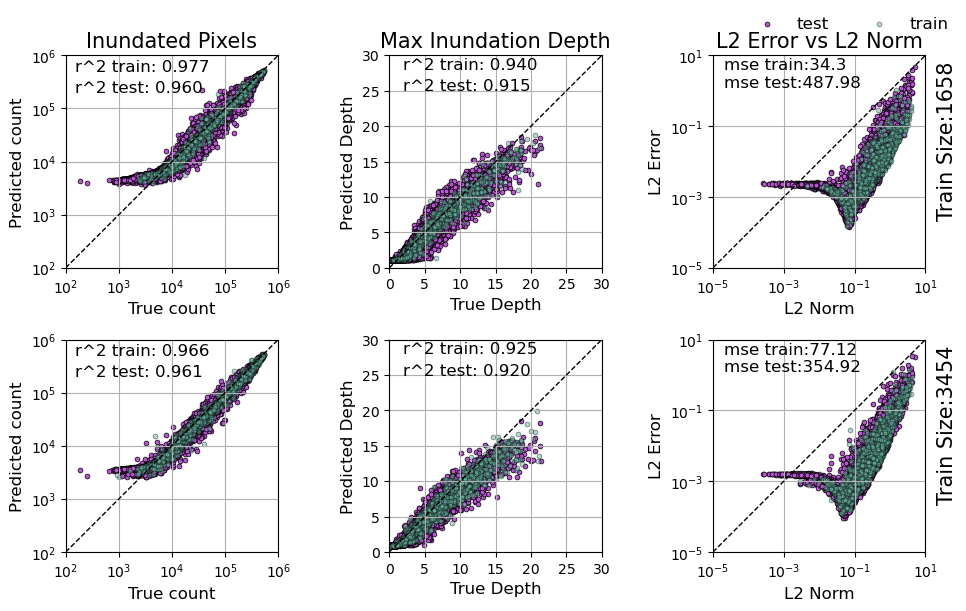

In [3]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'CT'

if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

# Create a single figure with three axes
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for t,train_size in enumerate(list_size[1:3]):
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_direct_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

    # Plot scatter of flood count
    x = eve_perf[eve_perf['split'] == 'test']['true']
    y = eve_perf[eve_perf['split'] == 'test']['pred']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    #add r2 score at bottom right of axis
    ax[t,0].text(150,2e5,f"r^2 test: {r2area:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['true']
    y = eve_perf[eve_perf['split'] == 'train']['pred']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    ax[t,0].text(150,5e5,f"r^2 train: {r2area:.3f} ", fontsize=12)
    
    if t == 0:
        ax[t,0].set_title("Inundated Pixels",fontsize=15)
    
    ax[t,0].plot([0, 1], [0, 1], transform=ax[t,0].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    ax[t,0].set_aspect('equal', adjustable='box')
    ax[t,0].set_xscale('log')
    ax[t,0].set_yscale('log')
    ax[t,0].set_xlim(100, 1000000)
    ax[t,0].set_ylim(100, 1000000)
    ax[t,0].grid()
    ax[t,0].minorticks_off()
    ax[t,0].set_xlabel('True count',fontsize=12)
    ax[t,0].set_ylabel('Predicted count',fontsize=12)

    # Plot scatter of max depth for each event
    # Calculate the point density
   
    # Plot scatter of max depth for each event
    x = eve_perf[eve_perf['split'] == 'test']['truemax']
    y = eve_perf[eve_perf['split'] == 'test']['predmax']
    scatter = ax[t,1].scatter(x, y,s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    r2maxdepth = r2_score(x, y)
    ax[t,1].text(2, 25, f"r^2 test: {r2maxdepth:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['truemax']
    y = eve_perf[eve_perf['split'] == 'train']['predmax']
    scatter = ax[t,1].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    
    r2maxdepth = r2_score(x, y)
    ax[t,1].text(2, 28, f"r^2 train: {r2maxdepth:.3f} ", fontsize=12)

    ax[t,1].plot([0, 1], [0, 1], transform=ax[t,1].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t ==0:
        ax[t,1].set_title("Max Inundation Depth",fontsize=15)
    ax[t,1].set_xlim(0, 30)
    ax[t,1].set_ylim(0, 30)
    ax[t,1].grid()
    ax[t,1].set_xlabel('True Depth',fontsize=12)
    ax[t,1].set_ylabel('Predicted Depth',fontsize=12)
    ax[t,1].set_aspect('equal', adjustable='box')
    ax[t,1].xaxis.set_ticks(np.arange(0, 35, 5))

    # Plot scatter of mse vs l2norm
    x = eve_perf[eve_perf['split'] == 'test']['l2n']
    y = eve_perf[eve_perf['split'] == 'test']['mse']
    para_test = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)

    x = eve_perf[eve_perf['split'] == 'train']['l2n']
    y = eve_perf[eve_perf['split'] == 'train']['mse']
    para_train = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    ax[t,2].text(0.05, 0.85, f"mse train:{para_train}\nmse test:{para_test}", fontsize=12,transform=ax[t,2].transAxes)
    
    ax[t,2].plot([0, 1], [0, 1], transform=ax[t,2].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t == 0:
        ax[t,2].set_title(f"L2 Error vs L2 Norm",fontsize=15)
    ax[t,2].set_aspect('equal', adjustable='box')
    ax[t,2].set_xscale('log')
    ax[t,2].set_yscale('log')
    ax[t,2].set_xlim(.00001, 10)
    ax[t,2].set_ylim(.00001, 10)
    ax[t,2].grid()
    ax[t,2].minorticks_off()
    ax[t,2].set_xlabel('L2 Norm',fontsize=12)
    ax[t,2].set_ylabel('L2 Error',fontsize=12)
    ax[t,2].text(1.1,0.6,f'Train Size:{train_size}',horizontalalignment='center',verticalalignment='center',transform=ax[t,2].transAxes,fontsize=15,rotation=90)


#save the plot
handles, labels = ax[t,2].get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper right', fontsize=12, ncol=2,bbox_to_anchor=(.98, 1.025),frameon= False)
plt.tight_layout()
plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/plots/combined_trainingsize{reg}_direct2.png',dpi=300, bbox_inches='tight')


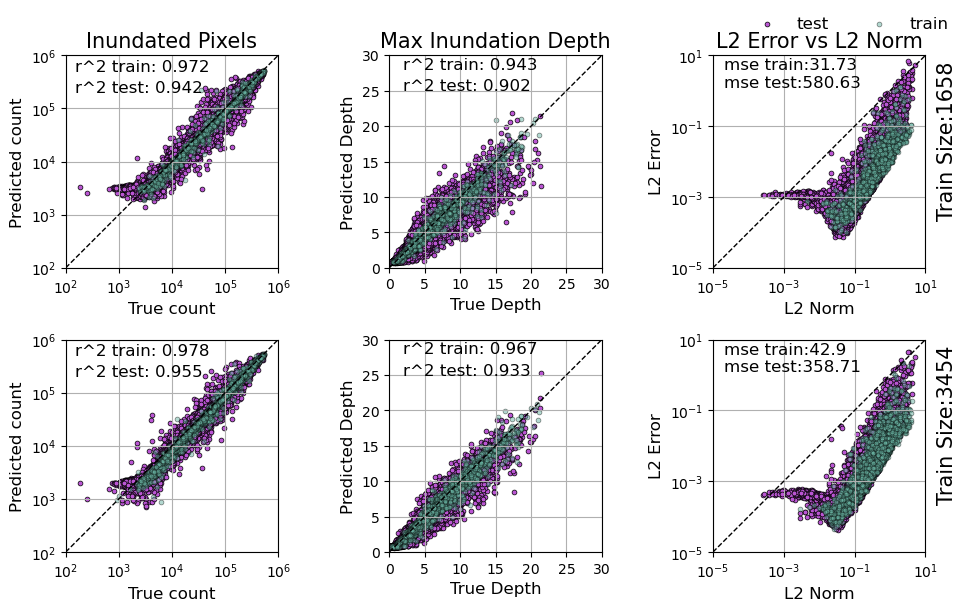

In [4]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'CT'

if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

# Create a single figure with three axes
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for t,train_size in enumerate(list_size[1:3]):
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_coupled_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

    # Plot scatter of flood count
    x = eve_perf[eve_perf['split'] == 'test']['true']
    y = eve_perf[eve_perf['split'] == 'test']['pred']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    #add r2 score at bottom right of axis
    ax[t,0].text(150,2e5,f"r^2 test: {r2area:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['true']
    y = eve_perf[eve_perf['split'] == 'train']['pred']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    ax[t,0].text(150,5e5,f"r^2 train: {r2area:.3f} ", fontsize=12)
    
    if t == 0:
        ax[t,0].set_title("Inundated Pixels",fontsize=15)
    
    ax[t,0].plot([0, 1], [0, 1], transform=ax[t,0].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    ax[t,0].set_aspect('equal', adjustable='box')
    ax[t,0].set_xscale('log')
    ax[t,0].set_yscale('log')
    ax[t,0].set_xlim(100, 1000000)
    ax[t,0].set_ylim(100, 1000000)
    ax[t,0].grid()
    ax[t,0].minorticks_off()
    ax[t,0].set_xlabel('True count',fontsize=12)
    ax[t,0].set_ylabel('Predicted count',fontsize=12)

    # Plot scatter of max depth for each event
    # Calculate the point density
   
    # Plot scatter of max depth for each event
    x = eve_perf[eve_perf['split'] == 'test']['truemax']
    y = eve_perf[eve_perf['split'] == 'test']['predmax']
    scatter = ax[t,1].scatter(x, y,s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    r2maxdepth = r2_score(x, y)
    ax[t,1].text(2, 25, f"r^2 test: {r2maxdepth:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['truemax']
    y = eve_perf[eve_perf['split'] == 'train']['predmax']
    scatter = ax[t,1].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    
    r2maxdepth = r2_score(x, y)
    ax[t,1].text(2, 28, f"r^2 train: {r2maxdepth:.3f} ", fontsize=12)

    ax[t,1].plot([0, 1], [0, 1], transform=ax[t,1].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t ==0:
        ax[t,1].set_title("Max Inundation Depth",fontsize=15)
    ax[t,1].set_xlim(0, 30)
    ax[t,1].set_ylim(0, 30)
    ax[t,1].grid()
    ax[t,1].set_xlabel('True Depth',fontsize=12)
    ax[t,1].set_ylabel('Predicted Depth',fontsize=12)
    ax[t,1].set_aspect('equal', adjustable='box')
    ax[t,1].xaxis.set_ticks(np.arange(0, 35, 5))

    # Plot scatter of mse vs l2norm
    x = eve_perf[eve_perf['split'] == 'test']['l2n']
    y = eve_perf[eve_perf['split'] == 'test']['mse']
    para_test = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)

    x = eve_perf[eve_perf['split'] == 'train']['l2n']
    y = eve_perf[eve_perf['split'] == 'train']['mse']
    para_train = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    ax[t,2].text(0.05, 0.85, f"mse train:{para_train}\nmse test:{para_test}", fontsize=12,transform=ax[t,2].transAxes)
    
    ax[t,2].plot([0, 1], [0, 1], transform=ax[t,2].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t == 0:
        ax[t,2].set_title(f"L2 Error vs L2 Norm",fontsize=15)
    ax[t,2].set_aspect('equal', adjustable='box')
    ax[t,2].set_xscale('log')
    ax[t,2].set_yscale('log')
    ax[t,2].set_xlim(.00001, 10)
    ax[t,2].set_ylim(.00001, 10)
    ax[t,2].grid()
    ax[t,2].minorticks_off()
    ax[t,2].set_xlabel('L2 Norm',fontsize=12)
    ax[t,2].set_ylabel('L2 Error',fontsize=12)
    ax[t,2].text(1.1,0.6,f'Train Size:{train_size}',horizontalalignment='center',verticalalignment='center',transform=ax[t,2].transAxes,fontsize=15,rotation=90)


#save the plot
handles, labels = ax[t,2].get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper right', fontsize=12, ncol=2,bbox_to_anchor=(.98, 1.025),frameon= False)
plt.tight_layout()
plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/plots/combined_trainingsize{reg}2.png',dpi=300, bbox_inches='tight')


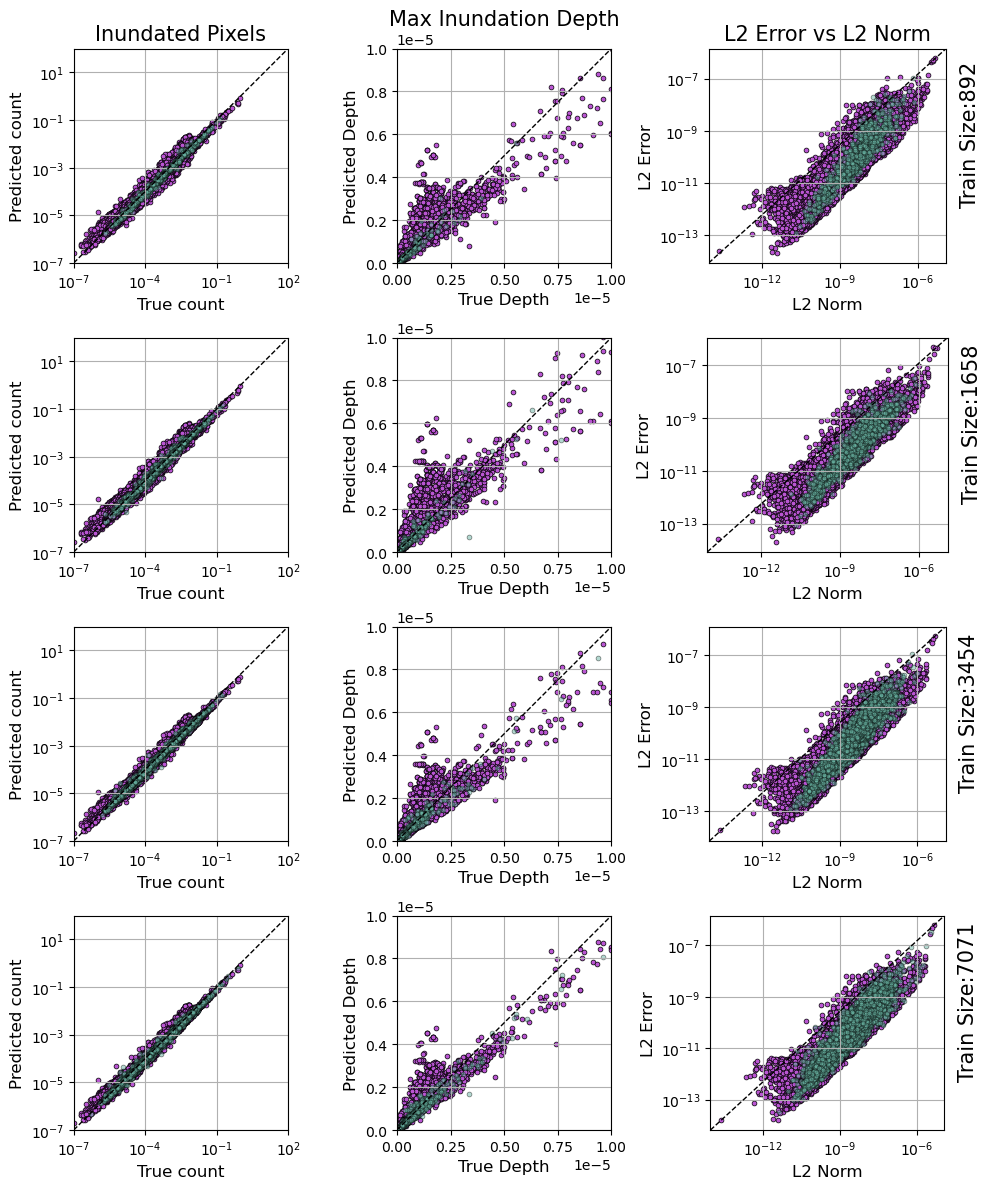

In [5]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'CT'

if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

# Create a single figure with three axes
fig, ax = plt.subplots(4, 3, figsize=(10, 12))
for t,train_size in enumerate(list_size):
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_direct_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

    # Plot scatter of flood count
    x = eve_perf[eve_perf['split'] == 'test']['true']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['pred']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    #add r2 score at bottom right of axis
    # ax[t,0].text(150,2e-5,f"r^2 test: {r2area:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['true']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['pred']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    # ax[t,0].text(150,5e-5,f"r^2 train: {r2area:.3f} ", fontsize=12)
    
    if t == 0:
        ax[t,0].set_title("Inundated Pixels",fontsize=15)
    
    ax[t,0].plot([0, 1], [0, 1], transform=ax[t,0].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    ax[t,0].set_aspect('equal', adjustable='box')
    ax[t,0].set_xscale('log')
    ax[t,0].set_yscale('log')
    ax[t,0].set_xlim(1e-7, 1e2)
    ax[t,0].set_ylim(1e-7, 1e2)
    ax[t,0].grid()
    ax[t,0].minorticks_off()
    ax[t,0].set_xlabel('True count',fontsize=12)
    ax[t,0].set_ylabel('Predicted count',fontsize=12)

    # Plot scatter of max depth for each event
    # Calculate the point density
   
    # Plot scatter of max depth for each event
    x = eve_perf[eve_perf['split'] == 'test']['truemax']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['predmax']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    scatter = ax[t,1].scatter(x, y,s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    r2maxdepth = r2_score(x, y)
    # ax[t,1].text(2, 25, f"r^2 test: {r2maxdepth:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['truemax']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['predmax']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    scatter = ax[t,1].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    
    r2maxdepth = r2_score(x, y)
    # ax[t,1].text(2, 28, f"r^2 train: {r2maxdepth:.3f} ", fontsize=12)

    ax[t,1].plot([0, 1], [0, 1], transform=ax[t,1].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t ==0:
        ax[t,1].set_title("Max Inundation Depth",fontsize=15)
    ax[t,1].set_xlim(0, 1e-5)
    ax[t,1].set_ylim(0, 1e-5)
    ax[t,1].grid()
    ax[t,1].set_xlabel('True Depth',fontsize=12)
    ax[t,1].set_ylabel('Predicted Depth',fontsize=12)
    ax[t,1].set_aspect('equal', adjustable='box')
    # ax[t,1].xaxis.set_ticks(np.arange(0, 35, 5))

    # Plot scatter of mse vs l2norm
    x = eve_perf[eve_perf['split'] == 'test']['l2n']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['mse']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']   
    para_test = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)

    x = eve_perf[eve_perf['split'] == 'train']['l2n']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['mse']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    para_train = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    # ax[t,2].text(0.05, 0.85, f"mse train:{para_train}\nmse test:{para_test}", fontsize=12,transform=ax[t,2].transAxes)
    
    ax[t,2].plot([0, 1], [0, 1], transform=ax[t,2].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t == 0:
        ax[t,2].set_title(f"L2 Error vs L2 Norm",fontsize=15)
    ax[t,2].set_aspect('equal', adjustable='box')
    ax[t,2].set_xscale('log')
    ax[t,2].set_yscale('log')
    # ax[t,2].set_xlim(.00001, 10)
    # ax[t,2].set_ylim(.00001, 10)
    ax[t,2].grid()
    ax[t,2].minorticks_off()
    ax[t,2].set_xlabel('L2 Norm',fontsize=12)
    ax[t,2].set_ylabel('L2 Error',fontsize=12)
    ax[t,2].text(1.1,0.6,f'Train Size:{train_size}',horizontalalignment='center',verticalalignment='center',transform=ax[t,2].transAxes,fontsize=15,rotation=90)


# #save the plot
# handles, labels = ax[t,2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='outside upper right', fontsize=12, ncol=2,bbox_to_anchor=(.98, 1.025),frameon= False)
plt.tight_layout()
# plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/plots/combined_trainingsize{reg}_direct.png',dpi=300, bbox_inches='tight')


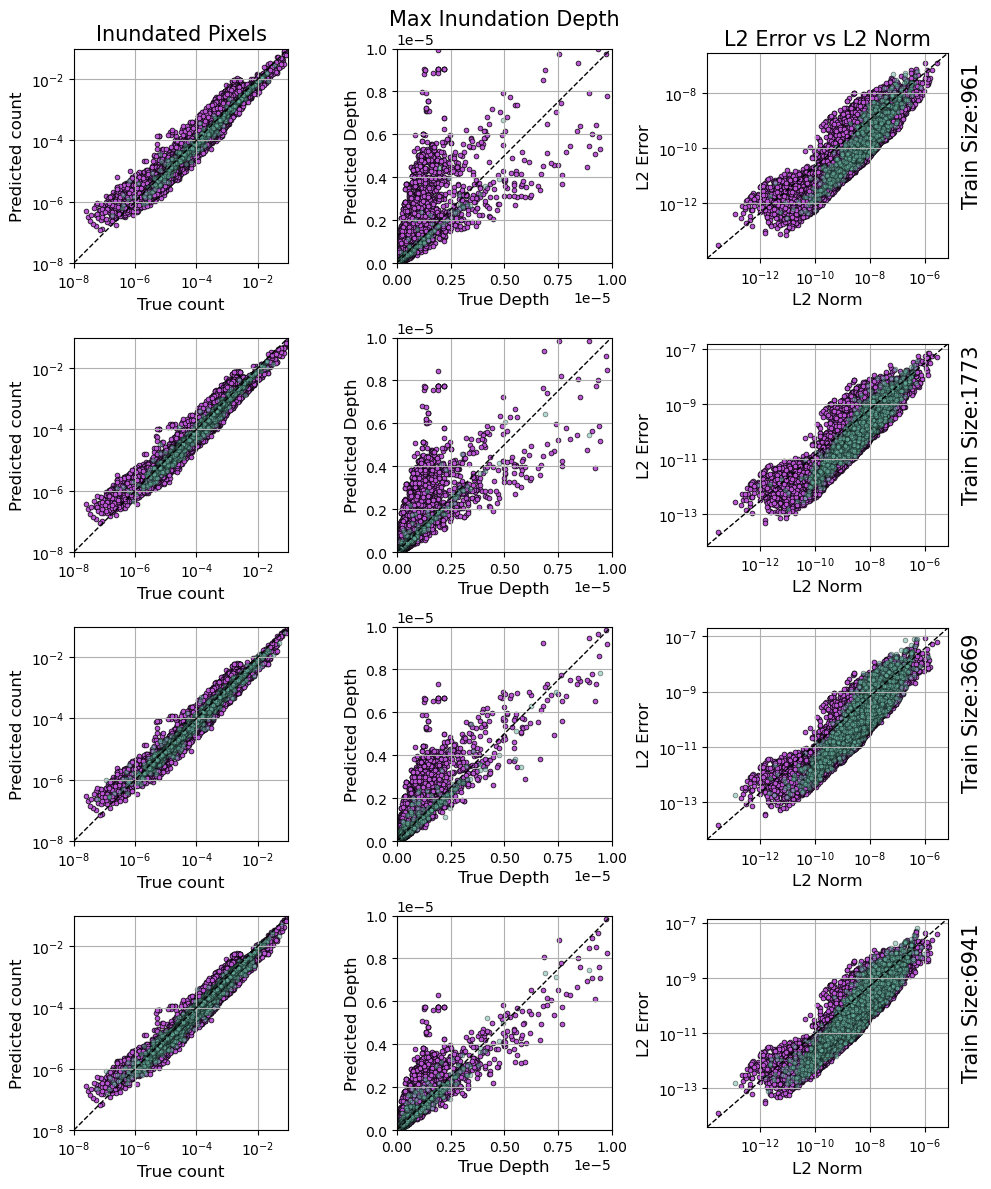

In [6]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'SR'

if reg == 'CT':
    columnname = str(38)
    list_size = ['892','1658','3454','7071']  
elif reg == 'SR':
    columnname = str(54)
    list_size = ['961','1773','3669','6941']

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"
mask_size = list_size[0]
train_size = list_size[1]

# Create a single figure with three axes
fig, ax = plt.subplots(4, 3, figsize=(10, 12))
for t,train_size in enumerate(list_size):
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_direct_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

    # Plot scatter of flood count
    x = eve_perf[eve_perf['split'] == 'test']['true']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['pred']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    #add r2 score at bottom right of axis
    # ax[t,0].text(150,2e-5,f"r^2 test: {r2area:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['true']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['pred']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    r2area = r2_score(x, y)
    scatter = ax[t,0].scatter(x, y, s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    # ax[t,0].text(150,5e-5,f"r^2 train: {r2area:.3f} ", fontsize=12)
    
    if t == 0:
        ax[t,0].set_title("Inundated Pixels",fontsize=15)
    
    ax[t,0].plot([0, 1], [0, 1], transform=ax[t,0].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    ax[t,0].set_aspect('equal', adjustable='box')
    ax[t,0].set_xscale('log')
    ax[t,0].set_yscale('log')
    ax[t,0].set_xlim(1e-8, 1e-1)
    ax[t,0].set_ylim(1e-8, 1e-1)
    ax[t,0].grid()
    ax[t,0].minorticks_off()
    ax[t,0].set_xlabel('True count',fontsize=12)
    ax[t,0].set_ylabel('Predicted count',fontsize=12)

    # Plot scatter of max depth for each event
    # Calculate the point density
   
    # Plot scatter of max depth for each event
    x = eve_perf[eve_perf['split'] == 'test']['truemax']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['predmax']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    scatter = ax[t,1].scatter(x, y,s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)
    r2maxdepth = r2_score(x, y)
    # ax[t,1].text(2, 25, f"r^2 test: {r2maxdepth:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['truemax']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['predmax']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    scatter = ax[t,1].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    
    r2maxdepth = r2_score(x, y)
    # ax[t,1].text(2, 28, f"r^2 train: {r2maxdepth:.3f} ", fontsize=12)

    ax[t,1].plot([0, 1], [0, 1], transform=ax[t,1].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t ==0:
        ax[t,1].set_title("Max Inundation Depth",fontsize=15)
    ax[t,1].set_xlim(0, 1e-5)
    ax[t,1].set_ylim(0, 1e-5)
    ax[t,1].grid()
    ax[t,1].set_xlabel('True Depth',fontsize=12)
    ax[t,1].set_ylabel('Predicted Depth',fontsize=12)
    ax[t,1].set_aspect('equal', adjustable='box')
    # ax[t,1].xaxis.set_ticks(np.arange(0, 35, 5))

    # Plot scatter of mse vs l2norm
    x = eve_perf[eve_perf['split'] == 'test']['l2n']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']
    y = eve_perf[eve_perf['split'] == 'test']['mse']*eve_perf[eve_perf['split'] == 'test']['mean_prob']*eve_perf[eve_perf['split'] == 'test']['max_off']   
    para_test = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y, s=12,label='test', c='mediumorchid',edgecolors="k",linewidths=0.5,alpha = 1)

    x = eve_perf[eve_perf['split'] == 'train']['l2n']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    y = eve_perf[eve_perf['split'] == 'train']['mse']*eve_perf[eve_perf['split'] == 'train']['mean_prob']*eve_perf[eve_perf['split'] == 'train']['max_off']
    para_train = np.sum(y).round(2)
    scatter = ax[t,2].scatter(x, y,s=12,label='train', c='#69b3a2',edgecolors="k",linewidths=0.5,alpha=0.5)
    # ax[t,2].text(0.05, 0.85, f"mse train:{para_train}\nmse test:{para_test}", fontsize=12,transform=ax[t,2].transAxes)
    
    ax[t,2].plot([0, 1], [0, 1], transform=ax[t,2].transAxes, color='k',linestyle = 'dashed',linewidth = 1)
    if t == 0:
        ax[t,2].set_title(f"L2 Error vs L2 Norm",fontsize=15)
    ax[t,2].set_aspect('equal', adjustable='box')
    ax[t,2].set_xscale('log')
    ax[t,2].set_yscale('log')
    # ax[t,2].set_xlim(.00001, 10)
    # ax[t,2].set_ylim(.00001, 10)
    ax[t,2].grid()
    ax[t,2].minorticks_off()
    ax[t,2].set_xlabel('L2 Norm',fontsize=12)
    ax[t,2].set_ylabel('L2 Error',fontsize=12)
    ax[t,2].text(1.1,0.6,f'Train Size:{train_size}',horizontalalignment='center',verticalalignment='center',transform=ax[t,2].transAxes,fontsize=15,rotation=90)


# #save the plot
# handles, labels = ax[t,2].get_legend_handles_labels()
# fig.legend(handles, labels, loc='outside upper right', fontsize=12, ncol=2,bbox_to_anchor=(.98, 1.025),frameon= False)
plt.tight_layout()
# plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/plots/combined_trainingsize{reg}_direct.png',dpi=300, bbox_inches='tight')
